## Luggagelosersからスクレイピング

### luggagelosersからのスクレイピングである。他のサイトから取得する航空会社名と一致する航空会社をデータとして活用したいため、国旗マーク除去、文字列小文字化、文字列内部の空白除去などの前処理を施した。このサイトからは主に各航空会社のロストバゲージ数のデータを抽出した。

In [1]:
import requests
from bs4 import BeautifulSoup
import re

def kokki_kill(text):
    emoji_pattern = re.compile("["
               u"\U0001F1E0-\U0001F1FF"  # 国旗
               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_airline_name(name):
    name = kokki_kill(name)
    return name.replace(" ", "").strip().lower()


lost_luggage_url = 'https://luggagelosers.com/'
response = requests.get(lost_luggage_url)
soup = BeautifulSoup(response.text, "html.parser")
table_tags = soup.find('table')
tr_tags = table_tags.find_all('tr')

airlines_lostbags_data = []
for tr in tr_tags:
    td_tags = tr.find_all('td')
    airline_lost_bags = td_tags[-1].get_text(strip=True)
    for td in td_tags:
        airline_tags = td.find_all('a')
        for airline_tag in airline_tags:
            airlines = clean_airline_name(airline_tag.get_text(strip=True))
            airlines_lostbags_data.append({
                "Airlines": airlines,
                "Lost_luggage": airline_lost_bags
            })
print(airlines_lostbags_data)


[{'Airlines': 'frontierairlines', 'Lost_luggage': '54,609'}, {'Airlines': 'airindia', 'Lost_luggage': '88,355'}, {'Airlines': 'indigo', 'Lost_luggage': '71,694'}, {'Airlines': 'britishairways', 'Lost_luggage': '83,967'}, {'Airlines': 'iberia', 'Lost_luggage': '24,143'}, {'Airlines': 'virginatlantic', 'Lost_luggage': '13,543'}, {'Airlines': 'pakistaninternationalairlines', 'Lost_luggage': '7,219'}, {'Airlines': 'emirates', 'Lost_luggage': '47,282'}, {'Airlines': 'ethiopianairlines', 'Lost_luggage': '12,575'}, {'Airlines': 'swiss', 'Lost_luggage': '9,683'}, {'Airlines': 'aerlingus', 'Lost_luggage': '8,742'}, {'Airlines': 'qatarairways', 'Lost_luggage': '33,885'}, {'Airlines': 'avianca', 'Lost_luggage': '24,153'}, {'Airlines': 'kenyaairways', 'Lost_luggage': '5,312'}, {'Airlines': 'royalairmaroc', 'Lost_luggage': '6,770'}, {'Airlines': 'aircanada', 'Lost_luggage': '22,653'}, {'Airlines': 'wizzair', 'Lost_luggage': '7,758'}, {'Airlines': 'klm', 'Lost_luggage': '13,504'}, {'Airlines': 'amer

## OAGからのスクレイピング

###各航空会社のOTP（定時運行率）をOAGのwebサイトから取得した。抽出したいデータがiframe内にあり,iframe内のデータへの対応、航空会社名の小文字化などの前処理も施した。

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
def clean_airline_name_oag(name):
    return clean_airline_name(name)
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
driver.get("https://www.oag.com/on-time-performance-global?submissionGuid=979215ee-32ea-46d7-8568-dbb97bd87839")
iframe = WebDriverWait(driver, 30).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, "iframe[src*='https://flo.uri.sh/visualisation/19357084/embed?auto=1']"))
)
driver.switch_to.frame(iframe)
print("ターゲットのiframeに切り替えました。")
oag_data = []
div_tags = driver.find_elements(By.CSS_SELECTOR, "div.tr.body-row")
for div in div_tags:
    ddiv_tags = div.find_elements(By.CSS_SELECTOR, "div.td")
    oag_airlines = ddiv_tags[0].text.strip()
    oag_airlines = clean_airline_name_oag(oag_airlines)
    otp = ddiv_tags[-3].text.strip()
    canceled_flights = ddiv_tags[-2].text.strip()
    total_flights = ddiv_tags[-1].text.strip()
    oag_data.append({
        "Airlines": oag_airlines,
        "OTP": otp,
        "Canceled_flights": canceled_flights,
        "Total_flights": total_flights
    })
driver.switch_to.default_content()
driver.quit()
print(oag_data)

ターゲットのiframeに切り替えました。
[{'Airlines': 'hainanairlines', 'OTP': '92.03%', 'Canceled_flights': '0.33%', 'Total_flights': '22637'}, {'Airlines': 'omanair', 'OTP': '91.61%', 'Canceled_flights': '0%', 'Total_flights': '3280'}, {'Airlines': 'royaljordanian', 'OTP': '91.38%', 'Canceled_flights': '0.08%', 'Total_flights': '2664'}, {'Airlines': 'safair', 'OTP': '90.69%', 'Canceled_flights': '0.14%', 'Total_flights': '5651'}, {'Airlines': 'xiamenairlinescompany', 'OTP': '90.65%', 'Canceled_flights': '0.04%', 'Total_flights': '19611'}, {'Airlines': 'copaairlines', 'OTP': '90.08%', 'Canceled_flights': '0.11%', 'Total_flights': '10780'}, {'Airlines': 'saudiarabianairlines', 'OTP': '89.78%', 'Canceled_flights': '0.07%', 'Total_flights': '16964'}, {'Airlines': 'starflyer', 'OTP': '89.75%', 'Canceled_flights': '0%', 'Total_flights': '1947'}, {'Airlines': 'fujidreamairlines', 'OTP': '89.09%', 'Canceled_flights': '0.31%', 'Total_flights': '2230'}, {'Airlines': 'japantransoceanair', 'OTP': '88.6%', 'Cancel

## DB作成、データ保存のためのclass・関数の定義

### 各航空会社のデータを管理するSqliteデータベースの操作クラス。

In [3]:
import sqlite3

class DBHandler:
    def __init__(self, db_path="flight_data.db"):
        self.db_path = db_path
        self.create_tables()

    def connect(self):
        return sqlite3.connect(self.db_path)

    def create_tables(self):
        conn = self.connect()
        cursor = conn.cursor() 
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS luggagelosers (
            id INTEGER PRIMARY KEY AUTOINCREMENT,  
            Airlines TEXT NOT NULL UNIQUE,
            Lost_luggage INTEGER NOT NULL
        )
        """)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS oag (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            Airlines TEXT NOT NULL UNIQUE,
            OTP TEXT,
            Canceled_flights TEXT,
            Total_flights TEXT
        )
        """)
        conn.commit()
        conn.close()

    def insert_luggagelosers(self, data_list):
        conn = self.connect()
        cursor = conn.cursor()
        for data in data_list:
            try:
                lost = int(data["Lost_luggage"].replace(',', ''))
            except ValueError:
                lost = 0
            cursor.execute("""
            INSERT OR IGNORE INTO luggagelosers (Airlines, Lost_luggage)
            VALUES (?, ?)
            """, (data["Airlines"], lost))
        conn.commit()
        conn.close()

    def insert_oag(self, data_list):
        conn = self.connect()
        cursor = conn.cursor()
        for data in data_list:
            cursor.execute("""
            INSERT OR IGNORE INTO oag (Airlines, OTP, Canceled_flights, Total_flights)
            VALUES (?, ?, ?, ?)
            """, (data["Airlines"], data["OTP"], data["Canceled_flights"], data["Total_flights"]))
        conn.commit()
        conn.close()

    def normalize_airlines(self, table_name):
        conn = self.connect()
        cursor = conn.cursor()
        cursor.execute(f"SELECT id, Airlines FROM {table_name}")
        rows = cursor.fetchall()
        for row in rows:
            record_id, airline_name = row
            normalized_name = clean_airline_name(airline_name)
            cursor.execute(f"""
            UPDATE {table_name}
            SET Airlines = ?
            WHERE id = ?
            """, (normalized_name, record_id))
        conn.commit()
        conn.close()

    def remove_duplicates(self, table_name):
        conn = self.connect()
        cursor = conn.cursor()
        cursor.execute(f"""
        DELETE FROM {table_name}
        WHERE id NOT IN (
            SELECT MIN(id)
            FROM {table_name}
            GROUP BY Airlines
        )
        """)
        conn.commit()
        conn.close()

    def query_joined_data(self):
        conn = self.connect()
        cursor = conn.cursor()
        query = """
        SELECT DISTINCT l.Airlines,
                        l.Lost_luggage,
                        o.OTP,
                        o.Canceled_flights,
                        o.Total_flights
        FROM luggagelosers l
        JOIN oag o ON l.Airlines = o.Airlines
        """
        cursor.execute(query)
        results = cursor.fetchall()
        conn.close()
        return results

    def delete_unmatched_airlines(self, table_name, common_airlines):
        conn = self.connect()
        cursor = conn.cursor()
        common_list = tuple(common_airlines)
        query = f"""
        DELETE FROM {table_name}
        WHERE Airlines NOT IN ({','.join('?' for _ in common_list)})
        """
        cursor.execute(query, common_list)
        conn.commit()
        conn.close()


## データベースの実行フロー

### 各航空会社のデータを表示させ、最終的な一致している航空会社数を表示

In [4]:
db = DBHandler("flight_data.db")

db.insert_luggagelosers(airlines_lostbags_data)
db.insert_oag(oag_data)

db.normalize_airlines("luggagelosers")
db.normalize_airlines("oag")


db.remove_duplicates("luggagelosers")
db.remove_duplicates("oag")

common_airlines = set(row[0] for row in db.query_joined_data())

db.delete_unmatched_airlines("luggagelosers", common_airlines)
db.delete_unmatched_airlines("oag", common_airlines)

joined_data = db.query_joined_data()
print("最終的なJOIN結果（不要データ削除後）:")
for row in joined_data:
    print(row)

print("最終的な一致している航空会社数:", len(joined_data))


最終的なJOIN結果（不要データ削除後）:
('airindia', 94181, '70.98%', '0.02%', '23300')
('britishairways', 87646, '69.03%', '3.21%', '24873')
('iberia', 26448, '85.68%', '0%', '18577')
('emirates', 49548, '79.56%', '0.03%', '14812')
('aerlingus', 10650, '77.74%', '2.26%', '8106')
('swiss', 10128, '72.4%', '1.31%', '11024')
('qatarairways', 34745, '86.75%', '0.12%', '16833')
('aircanada', 23168, '61.71%', '2.68%', '30936')
('americanairlines', 114677, '76.9%', '1.02%', '182456')
('aeromexico', 8222, '84.54%', '0.57%', '16247')
('deltaairlines', 70689, '79.97%', '0.35%', '144281')
('unitedairlines', 60087, '79.27%', '0.86%', '139874')
('etihadairways', 8683, '81.58%', '0.28%', '7896')
('spiritairlines', 9137, '77.48%', '0.53%', '21450')
('aireuropa', 3392, '82.54%', '0.16%', '5639')
('airfrance', 15474, '68.49%', '1.42%', '23306')
('pegasusairlines', 4808, '80.94%', '0%', '17104')
('brusselsairlines', 1936, '76.44%', '0.69%', '5052')
('alaskaairlines', 13548, '77.98%', '1.25%', '36768')
('icelandair', 144

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## データ分析・可視化

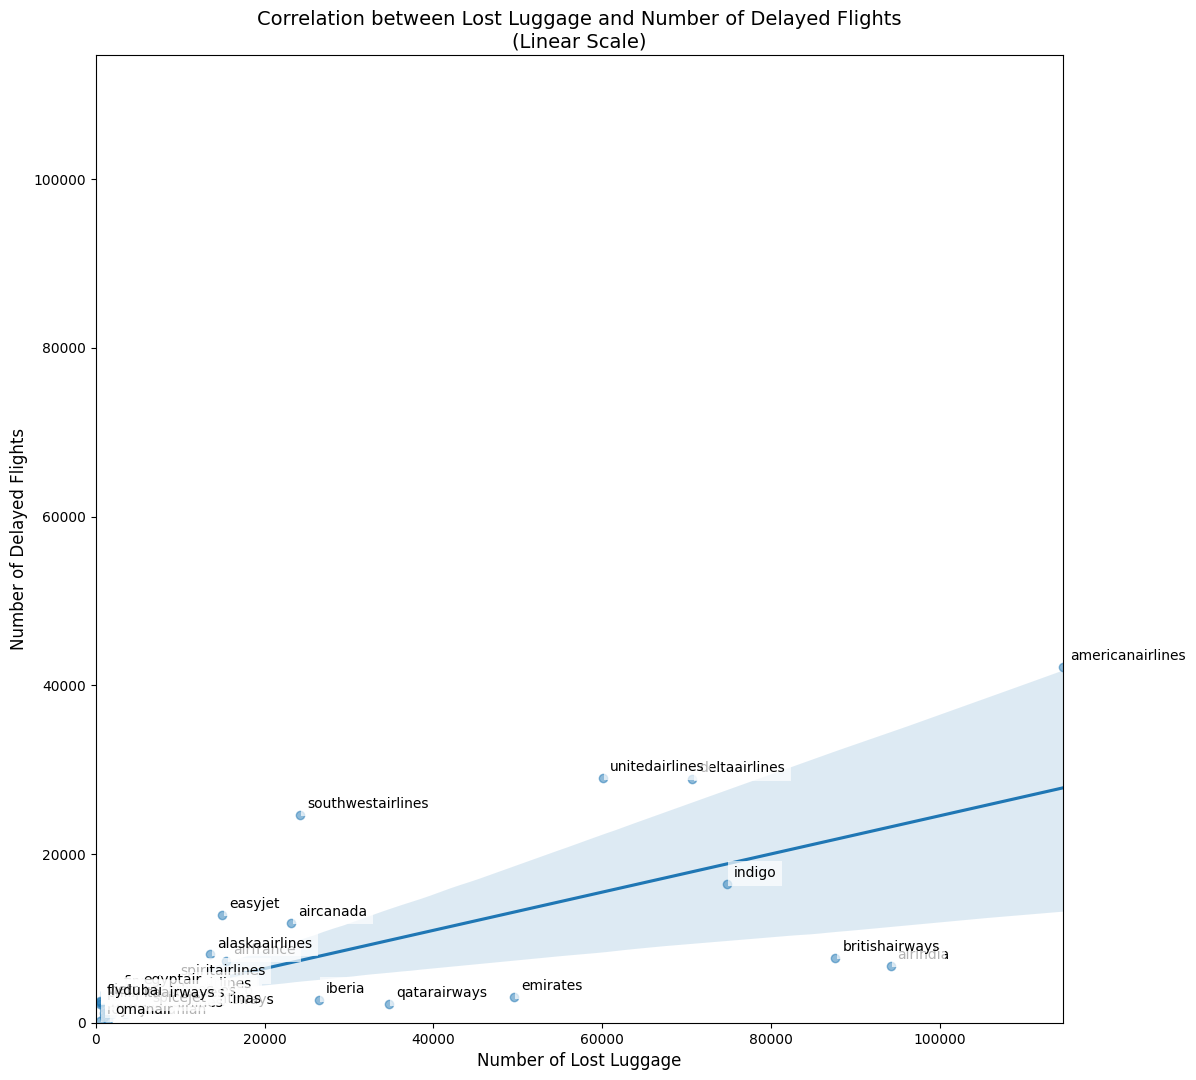

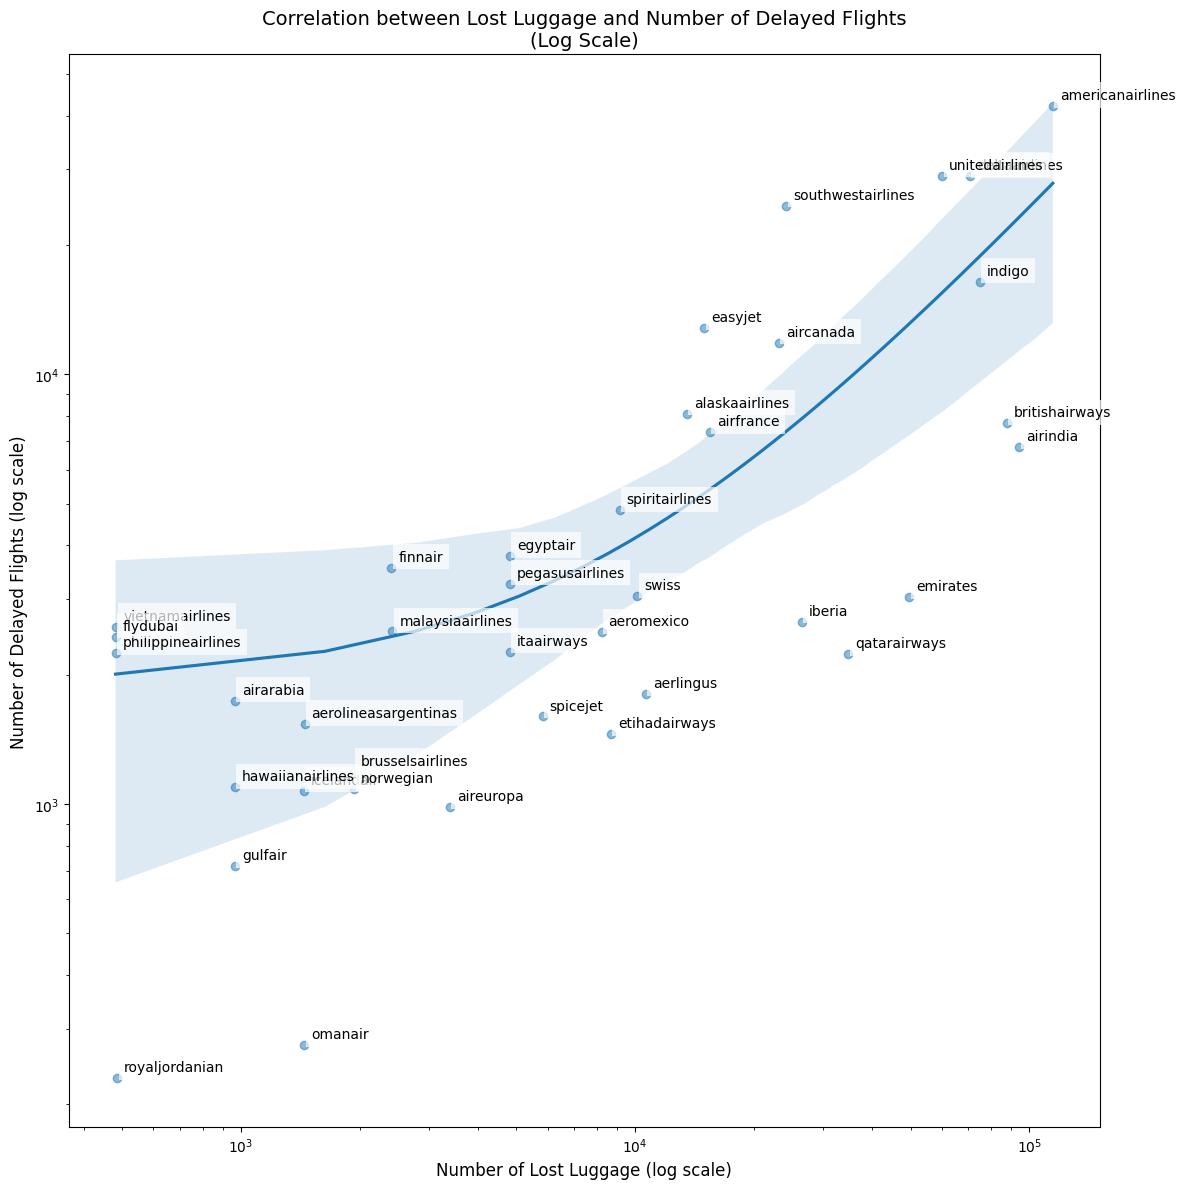

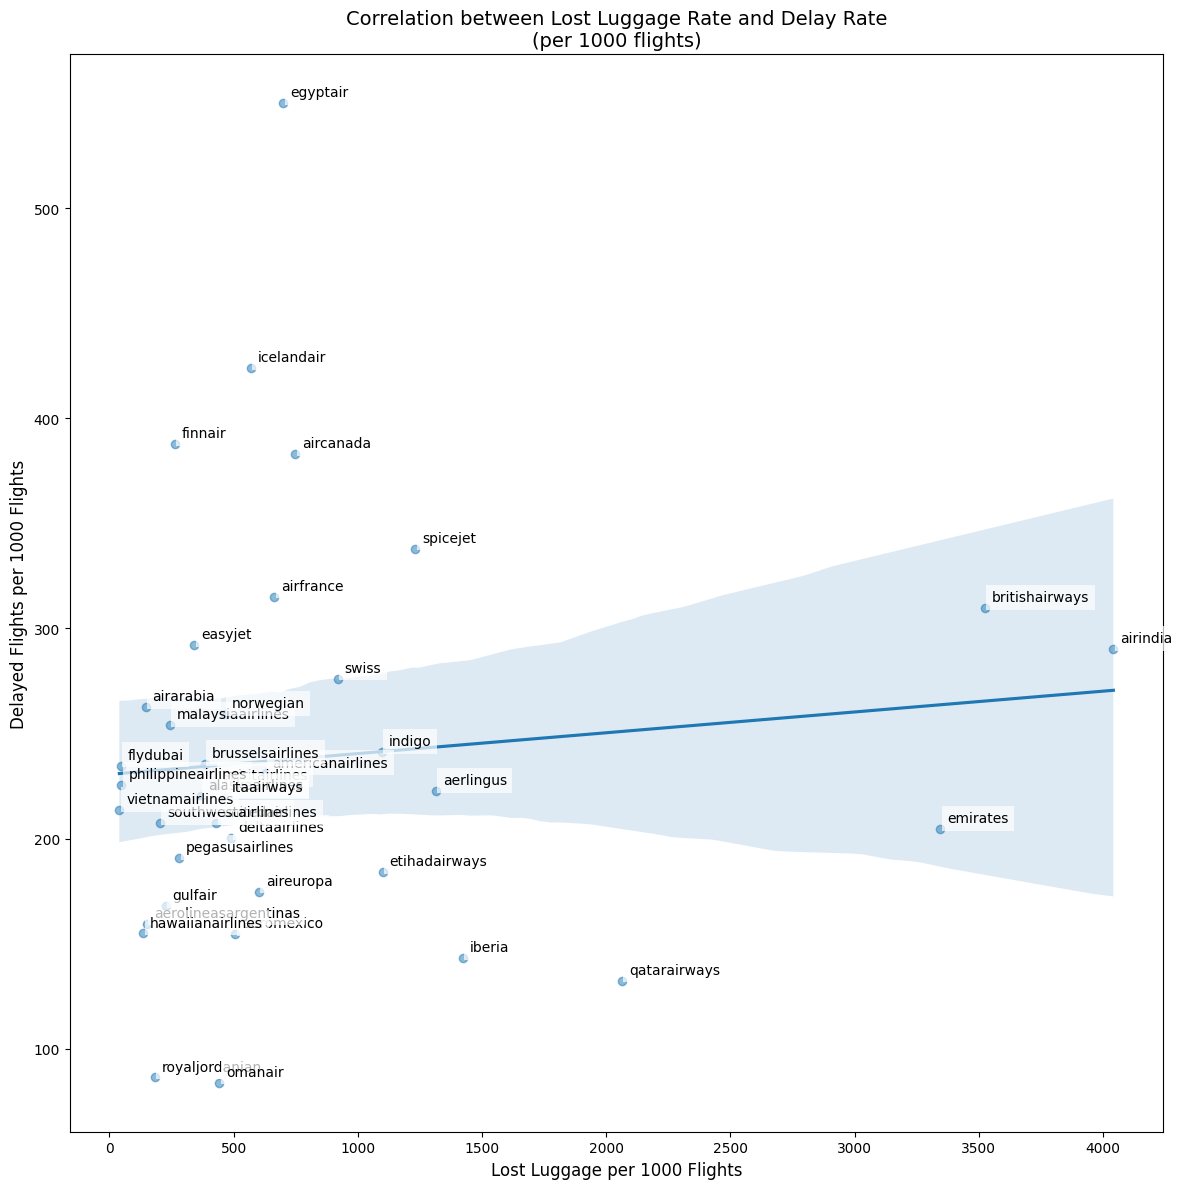


=== 絶対数での分析結果 ===
対象航空会社数: 38
相関係数: 0.723
P値: 0.000

=== 主要統計（絶対数） ===
平均ロストバゲージ数: 20855
平均遅延便数: 6617

ロストバゲージ最多航空会社: americanairlines
（114677件）

遅延便数最多航空会社: americanairlines
（42147便）

=== 正規化データの分析結果 ===
正規化後の相関係数: 0.103
P値: 0.540

=== 1000便あたりの統計 ===
平均ロストバゲージ率: 796.25件/1000便
平均遅延率: 238.46便/1000便

ロストバゲージ率最高航空会社: airindia
（4042.10件/1000便）

遅延率最高航空会社: egyptair
（549.90便/1000便）

=== 相関分析の解釈 ===
絶対数での相関係数 0.723 は強い相関を示しています。
正規化後の相関係数 0.103 は弱い相関を示しています。
絶対数での相関のみ統計的に有意です。

=== 分析データ ===
                Airlines  Lost_luggage  Lost_luggage_rate  Delayed_flights  Delay_rate  Total_flights    OTP
0               airindia         94181            4042.10             6762      290.21          23300  70.98
1         britishairways         87646            3523.74             7703      309.69          24873  69.03
2                 iberia         26448            1423.70             2660      143.19          18577  85.68
3               emirates         49548            3345.13             30

In [19]:
df = pd.DataFrame(joined_data, columns=['Airlines', 'Lost_luggage', 'OTP', 'Canceled_flights', 'Total_flights'])

df['OTP'] = df['OTP'].str.replace('%', '').str.replace(',', '').astype(float)
df['Total_flights'] = df['Total_flights'].str.replace(',', '').astype(int)
df['Lost_luggage'] = df['Lost_luggage'].astype(int)

df['Delayed_flights'] = ((100 - df['OTP']) / 100 * df['Total_flights']).round().astype(int)

df['Lost_luggage_rate'] = (df['Lost_luggage'] / df['Total_flights'] * 1000).round(2)
df['Delay_rate'] = (df['Delayed_flights'] / df['Total_flights'] * 1000).round(2)

correlation = stats.pearsonr(df['Lost_luggage'], df['Delayed_flights'])

normalized_correlation = stats.pearsonr(df['Lost_luggage_rate'], df['Delay_rate'])

plt.figure(figsize=(12, 12))  
sns.regplot(x='Lost_luggage', y='Delayed_flights', data=df, scatter_kws={'alpha':0.5})

max_value = max(df['Lost_luggage'].max(), df['Delayed_flights'].max())
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.gca().set_aspect('equal')
plt.title('Correlation between Lost Luggage and Number of Delayed Flights\n(Linear Scale)', fontsize=14)
plt.xlabel('Number of Lost Luggage', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)

for idx, row in df.iterrows():
    plt.annotate(
        row['Airlines'],
        xy=(row['Lost_luggage'], row['Delayed_flights']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
plt.tight_layout()
plt.savefig('correlation_analysis_linear.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 12))
sns.regplot(x='Lost_luggage', y='Delayed_flights', data=df, scatter_kws={'alpha':0.5})
plt.xscale('log')
plt.yscale('log')

plt.title('Correlation between Lost Luggage and Number of Delayed Flights\n(Log Scale)', fontsize=14)
plt.xlabel('Number of Lost Luggage (log scale)', fontsize=12)
plt.ylabel('Number of Delayed Flights (log scale)', fontsize=12)

for idx, row in df.iterrows():
    plt.annotate(
        row['Airlines'],
        xy=(row['Lost_luggage'], row['Delayed_flights']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
plt.tight_layout()
plt.savefig('correlation_analysis_log.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 12))
sns.regplot(x='Lost_luggage_rate', y='Delay_rate', data=df, scatter_kws={'alpha':0.5})

plt.title('Correlation between Lost Luggage Rate and Delay Rate\n(per 1000 flights)', fontsize=14)
plt.xlabel('Lost Luggage per 1000 Flights', fontsize=12)
plt.ylabel('Delayed Flights per 1000 Flights', fontsize=12)

for idx, row in df.iterrows():
    plt.annotate(
        row['Airlines'],
        xy=(row['Lost_luggage_rate'], row['Delay_rate']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
plt.tight_layout()
plt.savefig('normalized_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== 絶対数での分析結果 ===")
print(f"対象航空会社数: {len(df)}")
print(f"相関係数: {correlation[0]:.3f}")
print(f"P値: {correlation[1]:.3f}")

print("\n=== 主要統計（絶対数） ===")
print(f"平均ロストバゲージ数: {df['Lost_luggage'].mean():.0f}")
print(f"平均遅延便数: {df['Delayed_flights'].mean():.0f}")
print(f"\nロストバゲージ最多航空会社: {df.loc[df['Lost_luggage'].idxmax(), 'Airlines']}")
print(f"（{df['Lost_luggage'].max()}件）")
print(f"\n遅延便数最多航空会社: {df.loc[df['Delayed_flights'].idxmax(), 'Airlines']}")
print(f"（{df['Delayed_flights'].max()}便）")

print("\n=== 正規化データの分析結果 ===")
print(f"正規化後の相関係数: {normalized_correlation[0]:.3f}")
print(f"P値: {normalized_correlation[1]:.3f}")

print("\n=== 1000便あたりの統計 ===")
print(f"平均ロストバゲージ率: {df['Lost_luggage_rate'].mean():.2f}件/1000便")
print(f"平均遅延率: {df['Delay_rate'].mean():.2f}便/1000便")
print(f"\nロストバゲージ率最高航空会社: {df.loc[df['Lost_luggage_rate'].idxmax(), 'Airlines']}")
print(f"（{df['Lost_luggage_rate'].max():.2f}件/1000便）")
print(f"\n遅延率最高航空会社: {df.loc[df['Delay_rate'].idxmax(), 'Airlines']}")
print(f"（{df['Delay_rate'].max():.2f}便/1000便）")

def interpret_correlation(coef):
    if abs(coef) < 0.3:
        return "弱い"
    elif abs(coef) < 0.7:
        return "中程度"
    else:
        return "強い"

print("\n=== 相関分析の解釈 ===")
interpretation = interpret_correlation(correlation[0])
normalized_interpretation = interpret_correlation(normalized_correlation[0])
print(f"絶対数での相関係数 {correlation[0]:.3f} は{interpretation}相関を示しています。")
print(f"正規化後の相関係数 {normalized_correlation[0]:.3f} は{normalized_interpretation}相関を示しています。")
if correlation[1] < 0.05 and normalized_correlation[1] < 0.05:
    print("両方の相関は統計的に有意です。")
elif correlation[1] < 0.05:
    print("絶対数での相関のみ統計的に有意です。")
elif normalized_correlation[1] < 0.05:
    print("正規化後の相関のみ統計的に有意です。")
else:
    print("どちらの相関も統計的に有意ではありません。")

print("\n=== 分析データ ===")
print(df[['Airlines', 'Lost_luggage', 'Lost_luggage_rate', 'Delayed_flights', 'Delay_rate', 'Total_flights', 'OTP']].to_string())